# Imports

In [1]:
# ALL
import os
import random
import torch
import torchvision

# AS
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import segmentation_models_pytorch as smp

# FROM
from contextlib import redirect_stdout
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, f1_score, precision_score, recall_score, accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import OneHotEncoder
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms


# FROM .py FILES
from layers import *
from unet_parts import *


In [2]:
# Set the environment variable within Python
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

In [3]:
# CHeck whether the GPU is available for torch
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: mps


In [4]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
    

batch_size = 16
validation_split = .1
shuffle_dataset = True
random_seed= 42

# Loading Data

In [5]:
main_root_directory = "/Users/izzymohamed/Desktop/Fay/Data"

In [6]:
image_modal_directory = main_root_directory + "/images"
# forecasting_modal_directory = main_root_directory + "/forecasts"
# measurments_modal_directory = main_root_directory + "/measurements"

In [7]:
results_folder = "./results"

In [8]:
# Ensure results directory exists
os.makedirs(results_folder, exist_ok=True)

In [9]:
results_folder

'./results'

In [10]:
def collect_images_path_from_folder(folder_path):
    '''
    This function collects all the images from a folder and its subfolders
    '''
    files = []
    for r, d, f in os.walk(folder_path):
        for file in f:
            if '.png' in file:
                files.append(os.path.join(r, file))
    return files

In [11]:
# Create the collect df
def collect_files_from_directories(main_root_directory):
    '''
    This function collects all the files from the main root directory and its subfolders
    '''
    
    # Initialize an empty list to collect file info
    collected_files = []

    # Walk through the directory structure
    for root, dirs, files in os.walk(main_root_directory):
        # Check if the current folder is one of the categories
        for file in files:
            # Get filename without extension
            file_name = os.path.splitext(file)[0]
            # Construct the full file path
            file_path = os.path.join(root, file)
            # Collect the file path and category (folder name)
            collected_files.append((file_name, file_path))
    
    # Convert the collected file info into a DataFrame
    df = pd.DataFrame(collected_files, columns=['Filename', 'FilePath'])
    
    return df

In [12]:
def imshow(inp,dataloaders,class_names,title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

    inputs,classes= next(iter(dataloaders['Train']))

        # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    grid=imshow(out, title=[class_names[x] for x in classes])
    return grid

In [13]:
def display_images_with_text(images):
    '''
    This function displays images with text below each image
    '''
    plt.figure(figsize=(15, 15))  # Adjust figure size to accommodate 3x3 grid
    plt.suptitle("Sample Images", fontsize=16)

    # Ensure to display up to 9 images only
    for i in range(min(9, len(images))):
        img_name = images["Filename"][i]
        img_path = images["FilePath"][i]
        img = Image.open(img_path)

        # Calculate row and column position based on image index
        row = i // 3  # Integer division to get row index
        col = i % 3  # Remainder to get column index

        plt.subplot(3, 3, i + 1)  # Adjust subplot for a 3x3 grid
        plt.imshow(img)
        plt.axis('off')

        # Add text indicating the category/image name below each image
        plt.text(0, -10, f"{img_name}", color='white', fontsize=12, weight='bold', ha='left', va='bottom', bbox=dict(facecolor='black', alpha=0.7))

    plt.show()


In [14]:
images_df = collect_files_from_directories(image_modal_directory)

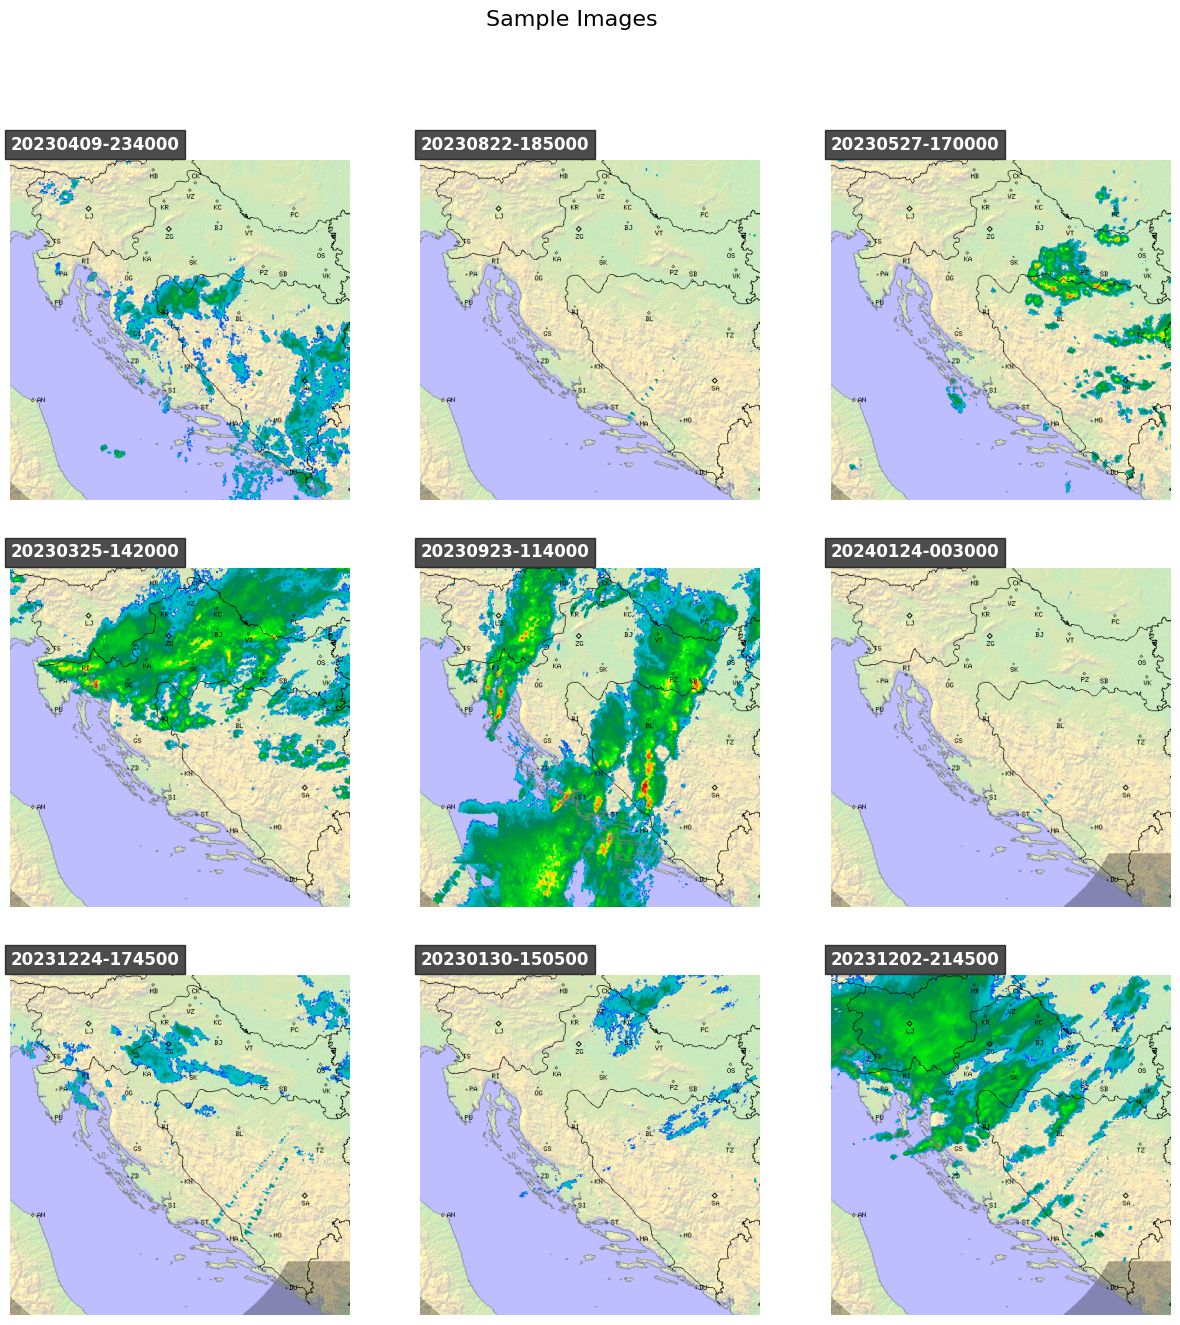

In [15]:
display_images_with_text(images_df)

In [16]:
class ForecastingDataset(Dataset):
    def __init__(self, root_dir, transform=None, sequence_length=1, target_samples=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            sequence_length (int): Number of images in each sequence.
            target_samples (int, optional): Target number of sequences to adjust to.
        """
    def __init__(self, root_dir, transform=None, sequence_length=1, target_samples=None):
        self.root_dir = root_dir
        self.transform = transform
        self.sequence_length = sequence_length
        
        all_files = sorted([f for f in os.listdir(root_dir) if not f.startswith(".")])
        self.image_paths = [os.path.join(root_dir, f) for f in all_files]

        if target_samples is not None and len(self.image_paths) > sequence_length:
            self.image_paths = self.adjust_sequence_distribution(self.image_paths, sequence_length, target_samples)

    def __len__(self):
        return max(0, len(self.image_paths) - self.sequence_length + 1)

    
    def __getitem__(self, idx):
        sequence_paths = self.image_paths[idx:idx + self.sequence_length]
        sequence = [Image.open(img_path).convert('RGB') for img_path in sequence_paths]

        if self.transform:
            sequence = [self.transform(image) for image in sequence]

        input_image = sequence[0]  # Use only the first image
        target_image = sequence[-1]  # Target remains the same

        return input_image, target_image

    @staticmethod
    def adjust_sequence_distribution(image_paths, sequence_length, target_samples):
        num_sequences = max(1, len(image_paths) - sequence_length + 1)
        indices = list(range(num_sequences))
        
        if num_sequences < target_samples:
            adjusted_indices = random.choices(indices, k=target_samples)
        else:
            adjusted_indices = random.sample(indices, k=target_samples)
        
        adjusted_image_paths = []
        for idx in adjusted_indices:
            adjusted_image_paths.extend(image_paths[idx:idx + sequence_length])
        
        return adjusted_image_paths

In [17]:
def split_into_trainvals(dataloaders, image_datasets):
    dataset_size = len(dataloaders.dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size, sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size, sampler=valid_sampler)
    
    dataset_sizes= {
    'train': len(train_indices),
    'val' :len(valid_sampler) 
    }

    return train_loader, validation_loader, dataset_sizes

In [18]:
def load_dataset(data_dir):
    image_datasets = datasets.ImageFolder(data_dir, data_transforms)
    dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=4, shuffle=True, num_workers=4)
    class_names = image_datasets.classes

    return dataloader, image_datasets, class_names

# Data Preprocessing

In [19]:
class PNGDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')  # Convert to RGB if necessary
        if self.transform:
            image = self.transform(image)
        return image

In [20]:
def create_data_loaders(data_dir, batch_size, train_val_test_split=(0.7, 0.2, 0.1), transform=None):
    image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.png')]
    
    # Split the data
    train_paths, test_paths = train_test_split(image_paths, test_size=(1 - train_val_test_split[0]))
    val_size = train_val_test_split[1] / (train_val_test_split[1] + train_val_test_split[2])
    val_paths, test_paths = train_test_split(test_paths, test_size=val_size)

    # Create datasets
    train_dataset = PNGDataset(train_paths, transform=transform)
    val_dataset = PNGDataset(val_paths, transform=transform)
    test_dataset = PNGDataset(test_paths, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [21]:
transform = transforms.Compose([transforms.Resize((500, 500)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])


In [22]:
# Initialize dataset

forecasting_dataset = ForecastingDataset(
    root_dir=image_modal_directory,
    transform=transform,
    sequence_length=5,  # Assuming 5-frame sequences
    target_samples=100  # Target number of sequences; adjust as needed
)


In [23]:
# Load the dataset
# dataloaders, image_datasets, class_names = load_dataset(image_modal_directory)

# Split the dataset into training and validation sets 
# train_loader, val_loader, dataset_sizes = split_into_trainvals(dataloaders, image_datasets)

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(image_modal_directory, 16, transform=transform)
    

# Training

In [24]:
# Define hyperparameters
n_channels = 3  # Number of input channels (e.g., 3 for RGB images)
n_classes = 2   # Number of output classes
batch_size = 2
learning_rate = 0.001
num_epochs = 1
grad_accumulation_steps = 4 

In [25]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, grad_accumulation_steps=1):
    
    '''
    This function trains a PyTorch model using the specified criterion and optimizer
    '''
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, images in enumerate(train_loader):
            images = images.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images) / grad_accumulation_steps  # Scale the loss
            
            # Backward pass
            loss.backward()
            
            if (i + 1) % grad_accumulation_steps == 0:
                # Perform a step of the optimizer and zero the gradients every grad_accumulation_steps
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * images.size(0) * grad_accumulation_steps
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')
        
        # Validation phase
        model.eval()  # Set model to evaluate mode
        with torch.no_grad():
            val_running_loss = 0.0
            for images in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_running_loss += loss.item() * images.size(0)

            val_epoch_loss = val_running_loss / len(val_loader.dataset)
            print(f'Validation Loss: {val_epoch_loss}')
            
    return model  # Return the trained model

### RESNET50

In [26]:
def fine_tune_model(model, output_features):

    num_ftrs = model.fc.in_features
    # output_features = 500  # Change this to match the size of your targets
    model.fc = nn.Linear(num_ftrs, output_features)
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda:0" if torch.cuda.is_available() else "cpu")
    model_ft = model.to(device)

    return model_ft

In [27]:
def prepare_resnet50(output_features, learning_rate=0.001):
    """
    Prepares a ResNet50 model for a forecasting task.
    
    Parameters:
    - output_features: The dimensionality of the output layer, corresponding to the number of features being forecasted.
    - learning_rate: Learning rate for the optimizer.
    
    Returns:
    - model: The ResNet50 model configured for forecasting.
    - criterion: Loss function suited for a regression task.
    - optimizer: Optimizer initialized with the model's parameters and specified learning rate.
    """
    model = models.resnet50(pretrained=True)
    # Adjusting the final layer for forecasting
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, output_features)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    return model, criterion, optimizer

In [28]:
# Prepare the model, criterion, and optimizer
resnet50, criterion, optimizer = prepare_resnet50(output_features=1, learning_rate=0.001)

# Train the model
# Ensure train_loader is correctly passed as the second argument
# resnet50_trained = train_model(resnet50, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
# # Save the model and the results
# resnet50_trained.save(results_folder + '/resnet50_model_pretrained.h5')

# # Save the model weights
# resnet50_trained.save_weights(results_folder + '/resnet50_model_pretrained_weights.h5')
# torch.save(resnet50_trained.state_dict(), os.path.join(results_folder, 'resnet50_model.pth'))

### UNET

In [30]:
class UNet(nn.Module):
    """
    Prepares a U-Net model for a forecasting task.

    Parameters:
    - encoder_name: Name of the encoder (backbone) to use for the U-Net.
    - encoder_weights: Pretrained weights for the encoder. Set to None for random initialization.
    - learning_rate: Learning rate for the optimizer.
    - in_channels: Number of input channels. For RGB images, this is 3.
    - out_channels: Number of output channels. This should match the dimensions of your forecasting target.

    Returns:
    - model: The U-Net model configured for forecasting.
    - criterion: Loss function suited for a regression task.
    - optimizer: Optimizer initialized with the model's parameters and specified learning rate.
    """
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512, bilinear=True)
        self.up2 = Up(512, 256, bilinear=True)
        self.up3 = Up(256, 128, bilinear=True)
        self.up4 = Up(128, 64, bilinear=True)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [31]:
# Assuming your dataset and DataLoader are set up for segmentation task
# train_loader should yield (images, masks) pairs
unet_model = UNet(n_channels=n_channels, n_classes=n_classes)

criterion = nn.CrossEntropyLoss()  # or another appropriate loss function for your task
optimizer = optim.Adam(unet_model.parameters(), lr=learning_rate)

unet_trained = train_model(unet_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 4

In [ ]:
# Save the model and the results
unet_trained.save(results_folder + '/unet_model_pretrained.h5')

# Save the model weights
torch.save(unet_trained.state_dict(), os.path.join(results_folder, 'unet_model.pth'))

### CONVLSTM

In [ ]:
class ConvLSTMCell(nn.Module):
    """
    Initialize a basic ConvLSTM cell.
    """
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Parameters:
            input_dim: Number of channels of input tensor.
            hidden_dim: Number of channels of hidden state.
            kernel_size: Size of the convolutional kernel.
            bias: Whether or not to add the bias.
        """
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,  # for input_gate, forget_gate, current_state, output_gate
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [ ]:
class ConvLSTM(nn.Module):
    """
    ConvLSTM layer for processing sequences of images.
    """
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True, return_all_layers=False):
        """
        Parameters:
            input_dim: Number of channels in the input image.
            hidden_dim: Number of channels in the hidden layers.
            kernel_size: Size of the convolutional kernel.
            num_layers: Number of ConvLSTM cells to stack.
            batch_first: Whether or not the batch dimension is the first dimension.
            bias: Whether to add a bias term to convolutional operations.
            return_all_layers: Whether to return outputs for all layers or just the last.
        """
        super(ConvLSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]
            # 1 -layer
            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size,
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters:
            input_tensor: 4D Tensor of shape (b, t, c, h, w) or (t, b, c, h, w)
            hidden_state: List of hidden states for each layer of the ConvLSTM.
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()
        hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append((h, c))

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        """
        Initialize the hidden state and cell state for all layers.
        """
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states


In [ ]:
def prepare_convlstm(input_dim, hidden_dim, kernel_size, num_layers, learning_rate=0.001):
    model = ConvLSTM(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=num_layers, batch_first=True, bias=True, return_all_layers=False)

    # Assuming the model is being used on a GPU if available
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()  # Assuming a regression task; adjust as needed
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    return model, criterion, optimizer

In [ ]:
# Define the ConvLSTM architecture parameters and setup
convlstm, convlstm_criterion, convlstm_optimizer = prepare_convlstm(input_dim=3, hidden_dim=[64, 64, 32], kernel_size=(3, 3), num_layers=3, learning_rate=0.001)

# Assuming you have a DataLoader that yields sequences of images for ConvLSTM
# Each batch should be of shape (batch_size, sequence_length, channels, height, width)
convlstm_trained = train_model(convlstm, convlstm_criterion, convlstm_optimizer, train_loader=train_loader, num_epochs=10)

# Save the model and the results
convlstm_trained.save(results_folder + '/convlstm_model_pretrained.h5')
torch.save(convlstm_trained.state_dict(), os.path.join(results_folder, 'convlstm_model.pth'))

# Evaluate

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    pred_scores = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            scores = torch.softmax(outputs, dim=1)
            _, preds = torch.max(scores, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_scores.extend(scores.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    return np.array(true_labels), np.array(pred_scores), np.array(pred_labels)


In [ ]:
true_labels, pred_scores, pred_labels = evaluate_model(model, validation_loader)

# Prediction
To calculate additional metrics, you'll need the model's predictions on the test set.

In [ ]:
def predict_and_display(model, data_loader):
    model.eval()
    images, labels = next(iter(data_loader))  # Get one batch of data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Display images and predictions
    plt.figure(figsize=(10, 10))
    for i in range(4):  # Display first 4 images in the batch
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
        plt.title(f"True: {labels[i].item()}, Pred: {predicted[i].item()}")
        plt.axis('off')
    plt.show()

    return images, labels, predicted

# Report

### Calculate

In [ ]:
def generate_reports(true_labels, pred_scores, pred_labels, class_names):
    # Classification Report
    print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=class_names))

    # Micro and Macro averages
    precision_micro = precision_score(true_labels, pred_labels, average='micro')
    recall_micro = recall_score(true_labels, pred_labels, average='micro')
    f1_micro = f1_score(true_labels, pred_labels, average='micro')

    precision_macro = precision_score(true_labels, pred_labels, average='macro')
    recall_macro = recall_score(true_labels, pred_labels, average='macro')
    f1_macro = f1_score(true_labels, pred_labels, average='macro')

    print(f"Micro Average Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1-Score: {f1_micro:.4f}")
    print(f"Macro Average Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-Score: {f1_macro:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(f"{results_folder}/confusion_matrix.png")
    plt.show()

    num_classes = len(class_names)
    if num_classes == 2:
        # Binary classification metrics
        roc_auc = roc_auc_score(true_labels, pred_scores[:, 1])
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        # Multi-class specific metrics
        for i in range(num_classes):
            precision, recall, _ = precision_recall_curve(true_labels == i, pred_scores[:, i])
            pr_auc = average_precision_score(true_labels == i, pred_scores[:, i])
            plt.figure()
            plt.step(recall, precision, where='post', label=f'PR Curve (area={pr_auc:.2f})')
            plt.fill_between(recall, precision, alpha=0.2)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.title(f'Class {class_names[i]} Precision-Recall curve')
            plt.savefig(f"{results_folder}/precision_recall_curve_class_{i}.png")
            plt.legend(loc="upper right")
            plt.show()

In [ ]:
def calculate_additional_metrics(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0
    pred_probs = []
    true_labels_list = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # For log loss calculation
            softmax_outputs = torch.nn.functional.softmax(outputs, dim=1)
            pred_probs.extend(softmax_outputs.cpu().numpy())
            true_labels_list.extend(labels.cpu().numpy())

    avg_loss = total_loss / total
    accuracy = correct / total
    mmce = 1 - accuracy
    logloss = log_loss(true_labels_list, pred_probs)
    mae = mean_absolute_error(true_labels_list, np.argmax(pred_probs, axis=1))
    mse = mean_squared_error(true_labels_list, np.argmax(pred_probs, axis=1))
    f1score = f1_score(true_labels_list, np.argmax(pred_probs, axis=1), average='weighted')

    return avg_loss, accuracy, mmce, logloss, mae, mse, f1score

In [ ]:
# Generate report for the model
generate_reports(true_labels, pred_scores, pred_labels, class_names=['Class0', 'Class1', 'Class2', 'Class3'])

In [ ]:
criterion = torch.nn.CrossEntropyLoss()  # or other appropriate loss function

### Save

In [ ]:
def save_evaluation_results(results_folder, metrics, class_names, true_labels, pred_labels):
    test_loss, test_accuracy, mmce, log_loss_val, mae, mse, f1score = metrics

    with open(os.path.join(results_folder, 'evaluation_results.txt'), 'w') as f:
        f.write(f'Test Loss: {test_loss:.4f}\n')
        f.write(f'Test Accuracy: {test_accuracy:.4f}\n')
        f.write(classification_report(true_labels, pred_labels, target_names=class_names))
        f.write(f'MMCE: {mmce:.4f}\n')
        f.write(f'Log Loss: {log_loss_val:.4f}\n')
        f.write(f'Mean Absolute Error: {mae:.4f}\n')
        f.write(f'Mean Squared Error: {mse:.4f}\n')
        f.write(f'F1 Score: {f1score:.4f}\n')